In [1]:
sys.path.append('../jax_healpix/')
from SPHT_jax import *
from YLM_jax import *
from utils import *
from reshape_utils import *

In [2]:
from scipy.special import binom, jn, loggamma
from scipy.special import eval_jacobi as jacobi

In [3]:
def log_binom(x,y):
    return loggamma(x+1)-loggamma(y+1)-loggamma(x-y+1)

In [4]:
def wigner_d2(m1, m2, theta, l, l_use_bessel=1.0e3):
    """
    Function to compute wigner small-d matrices.
    This maybe less accurate than our main jax functions which use recursion.
    """
    l=l[:,None,None]
    m2=m2[None,:,None]
    m1=m1*np.ones_like(m2)
    theta=theta[None,None,:]
    k = np.amin([l - m1, l - m2, l + m1, l + m2], axis=0)
    a = np.absolute(m1 - m2)
    lamb = m2 - m1  # lambda
    x=m2<=m1
    lamb[x]=0
    b = 2 * l - 2 * k - a

#     d_mat = np.sqrt(
#         binom(2 * l - k, k + a)
#     )
    d_mat=0.5*log_binom(2 * l - k, k + a)
    
#     d_mat /= np.sqrt(binom(k + b, b))
    d_mat-=0.5*log_binom(k + b, b)
    x = k+b < b
    d_mat[x] = -np.inf
  
    beta_s=np.sin(theta / 2.0)
    beta=np.cos(theta / 2.0)
    
    d_mat=d_mat+a*np.log(np.absolute(beta_s))+b*np.log(np.absolute(beta))
    sign_dmat=np.sign(beta_s)**a
    sign_dmat=sign_dmat*(np.sign(beta)**b)
    
    d_mat=sign_dmat*np.exp(d_mat)
#     d_mat[x]=0
    x = d_mat == 0
    d_mat *= jacobi(k, a, b, np.cos(theta))  # l
    
    d_mat*=(-1)**lamb[0,:,0][None,:,None]
    
    d_mat[x] = 0

    if l_use_bessel is not None:
        x = l[:,0,0] >= l_use_bessel

        d_mat[x,:,:]=jn(m1-m2,l[x,:,:]*theta)
    return d_mat


In [5]:
theta=np.linspace(1.e-2,np.pi*.95,20)
beta=np.cos(theta)

In [6]:
l_max=500
l=np.arange(l_max)
# l=np.arange(900,l_max)
m1=0
m2=l*1.

In [7]:
wig_d2=wigner_d_parallel(m1,m2[0],theta,l,ncpu=10)
%time wig_d=wigner_d2(m1,m2,theta,l*1.)

np.all(np.isclose(wig_d2.T,wig_d[:,0,:]))

CPU times: user 3.38 s, sys: 62.1 ms, total: 3.44 s
Wall time: 3.44 s


True

In [8]:
ylm2=wig_d*np.sqrt(2*l[:,None,None]+1)/np.sqrt(4*np.pi)
np.all(np.isfinite(wig_d))

True

In [9]:
%time ylm=sYLM_recur(beta=beta,spins=(0,),l_max=l_max-1)

CPU times: user 66.6 ms, sys: 22.9 ms, total: 89.5 ms
Wall time: 88.4 ms


/home/deep/repos/SPHT/notebooks/../jax_healpix/YLM_jax.py:60: RuntimeWarning: divide by zero encountered in log
  log_Alm = -1 * logdiffexp(2 * np.log(l), 2 * np.log(m))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:15: RuntimeWarning: divide by zero encountered in log
  log_diff = np.log(1 - np.exp(log_b - log_a))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:15: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(1 - np.exp(log_b - log_a))


In [10]:
lt=240
mt=10
theta_i=0
ylm[0][lt,mt,theta_i], ylm2[lt,mt,theta_i] 
# https://www.wolframalpha.com/input?i=SphericalHarmonicY%281%2C0%2C0.47966%2C0%29

(9.417509569364824e-06, 9.417509569350789e-06)

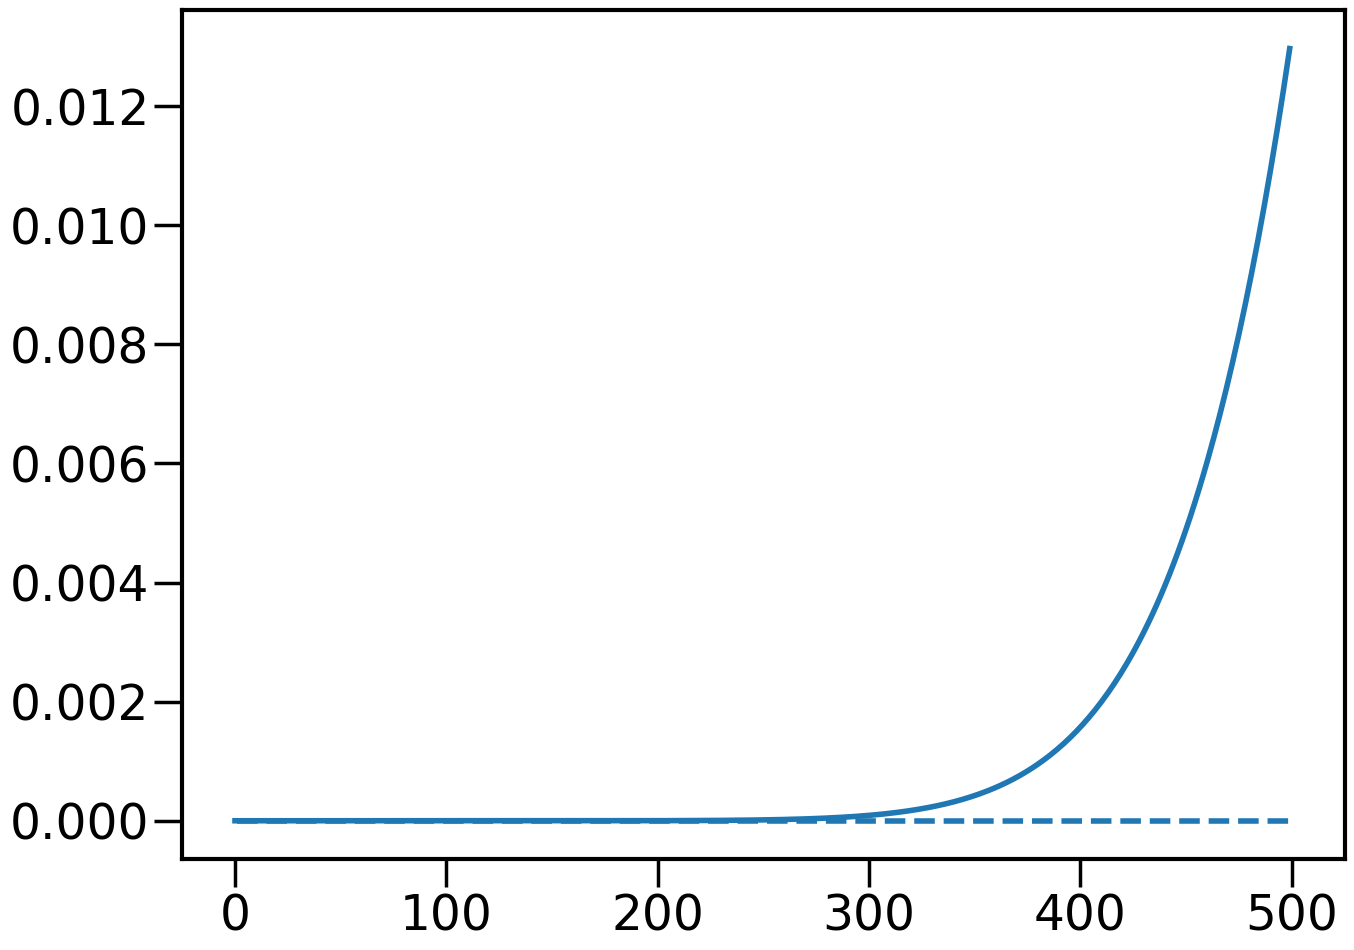

In [11]:
plot(l,ylm[0][:,mt,theta_i])
hlines(0,1,500,ls='--')
# https://www.wolframalpha.com/input?i=plot%5BSphericalHarmonicY%28x%2C0%2C0.01%2C0%29%2C%7Bx%2C0%2C500%7D%5D

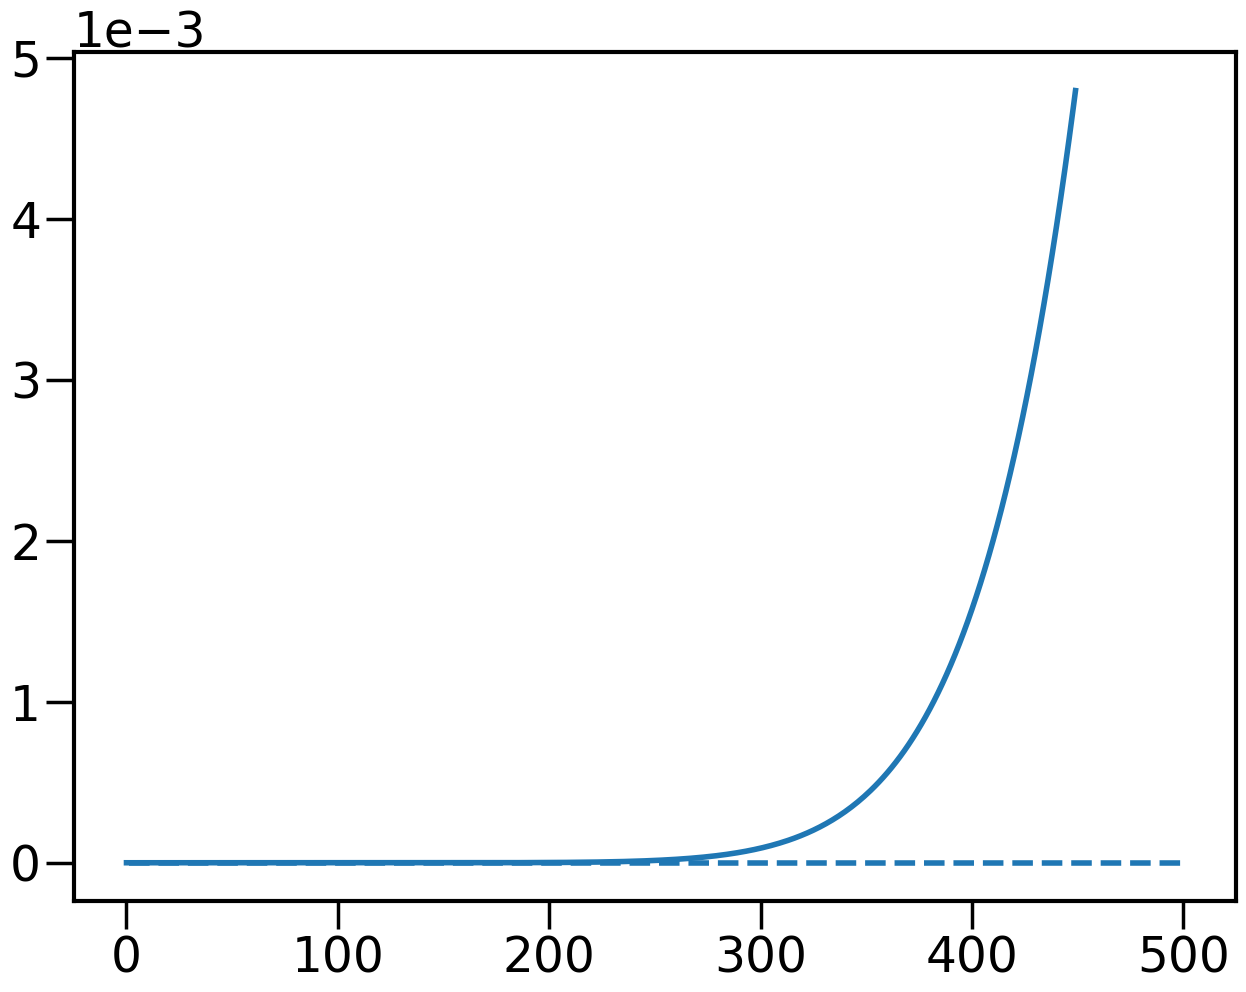

In [12]:
plot(l[:450],ylm[0][:450,mt,theta_i])
hlines(0,1,500,ls='--')
# https://www.wolframalpha.com/input?i=plot%5BSphericalHarmonicY%28x%2C0%2C0.01%2C0%29%2C%7Bx%2C0%2C500%7D%5D

In [13]:
theta[theta_i], beta[theta_i]

(0.01, 0.9999500004166653)

In [14]:
ylm2.shape

(500, 500, 20)

In [15]:
ylm[0][lt,mt,:]

array([ 9.41750957e-06,  7.51672205e-01,  3.07623073e-01,  1.40424935e-01,
        5.67060782e-02,  4.93336777e-03, -3.20461343e-02, -6.14345163e-02,
       -8.68389353e-02, -1.10372413e-01, -1.33495168e-01, -1.57424172e-01,
       -1.83395818e-01, -2.12915539e-01, -2.48107803e-01, -2.92351140e-01,
       -3.51617510e-01, -4.37507809e-01, -5.71935886e-01, -6.71691056e-01])

In [16]:
0.28209478*beta[theta_i]*sqrt(3)

0.48857806158897293

In [17]:
lt=0
ylm[0][lt+1,lt,:]/ylm[0][lt,lt,:]/(np.sqrt(2*lt+3))

array([ 0.99995   ,  0.98616203,  0.9482536 ,  0.8871519 ,  0.80435142,
        0.70187737,  0.58223616,  0.44835407,  0.30350573,  0.15123396,
       -0.00473682, -0.16059175, -0.31251878, -0.45680194, -0.58991221,
       -0.70859386, -0.80994407, -0.89148392, -0.95121903, -0.98768834])

In [18]:
np.all(np.isfinite(ylm[0])), np.all(np.isfinite(ylm2))

(True, True)

In [19]:
lt=1
mt=0
np.isclose(ylm[0][lt,mt,:],ylm2[lt,mt,:])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [21]:
rr=ylm[0]/ylm2
x=abs(ylm2)<1.e-20
rr[x]=1
rr.min(),rr.max()

/tmp/ipykernel_1579937/1439460242.py:1: RuntimeWarning: divide by zero encountered in true_divide
  rr=ylm[0]/ylm2
/tmp/ipykernel_1579937/1439460242.py:1: RuntimeWarning: invalid value encountered in true_divide
  rr=ylm[0]/ylm2


(0.9999999850894599, 1.0000002477160124)

In [22]:
xx=np.where(abs(1-rr)>.1)
len(xx[0])

0

In [23]:
np.cos(theta[xx[2]])

array([], dtype=float64)

In [24]:
xx[0].shape

(0,)

In [25]:
l[np.array(xx[0])]

array([], dtype=int64)

In [26]:
l[np.array(xx[1])]

array([], dtype=int64)

In [27]:
theta[3]

0.47965995067004796

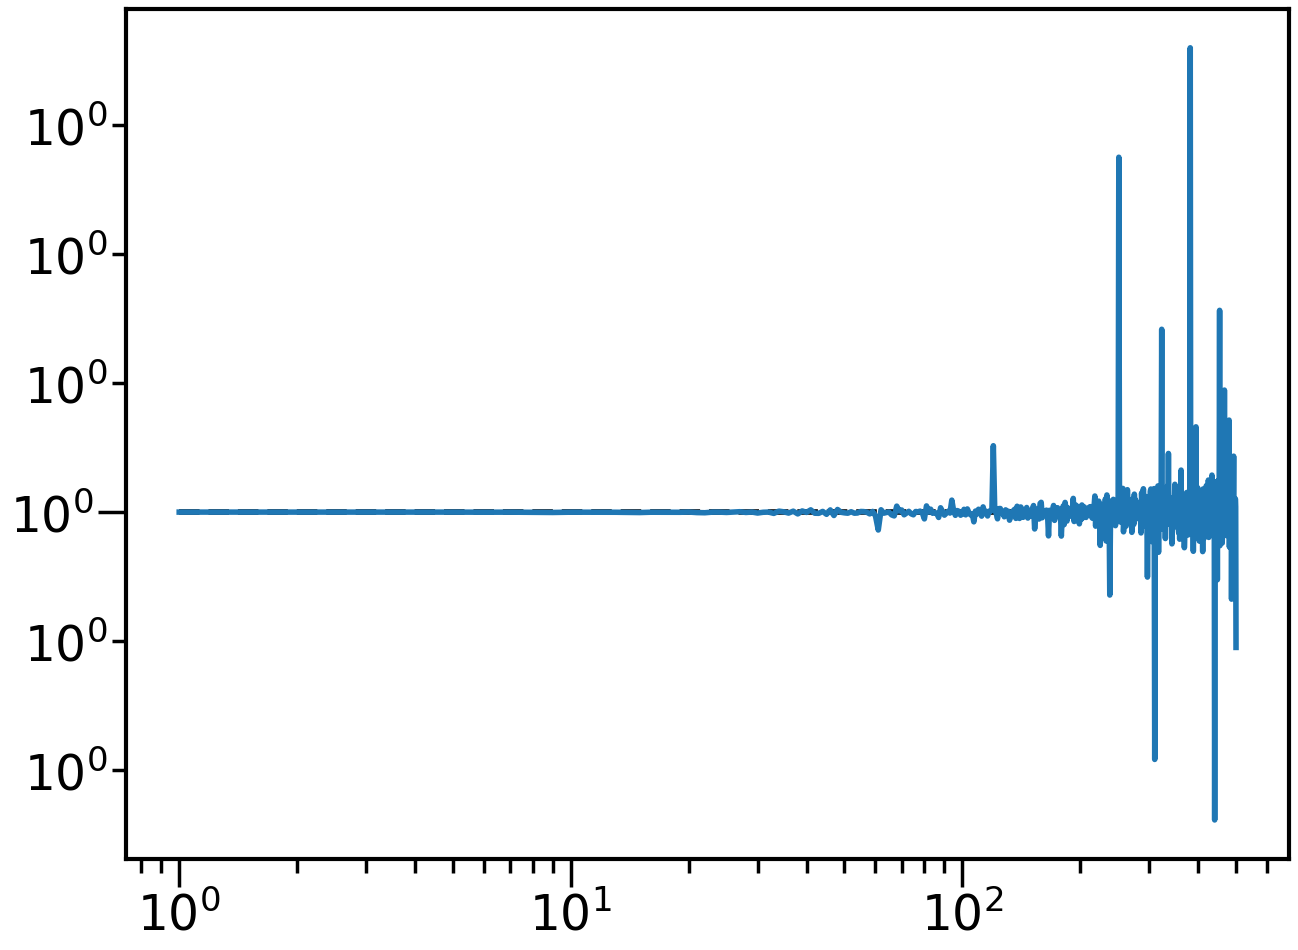

In [28]:
theta_i=3
m2_i=1
# for theta_i in range(len(theta)):
plot(l+1,rr[:,m2_i,theta_i])
xscale('log')
yscale('log')
hlines(1,1,500,color='k',ls='--')
# xlim(238,245)

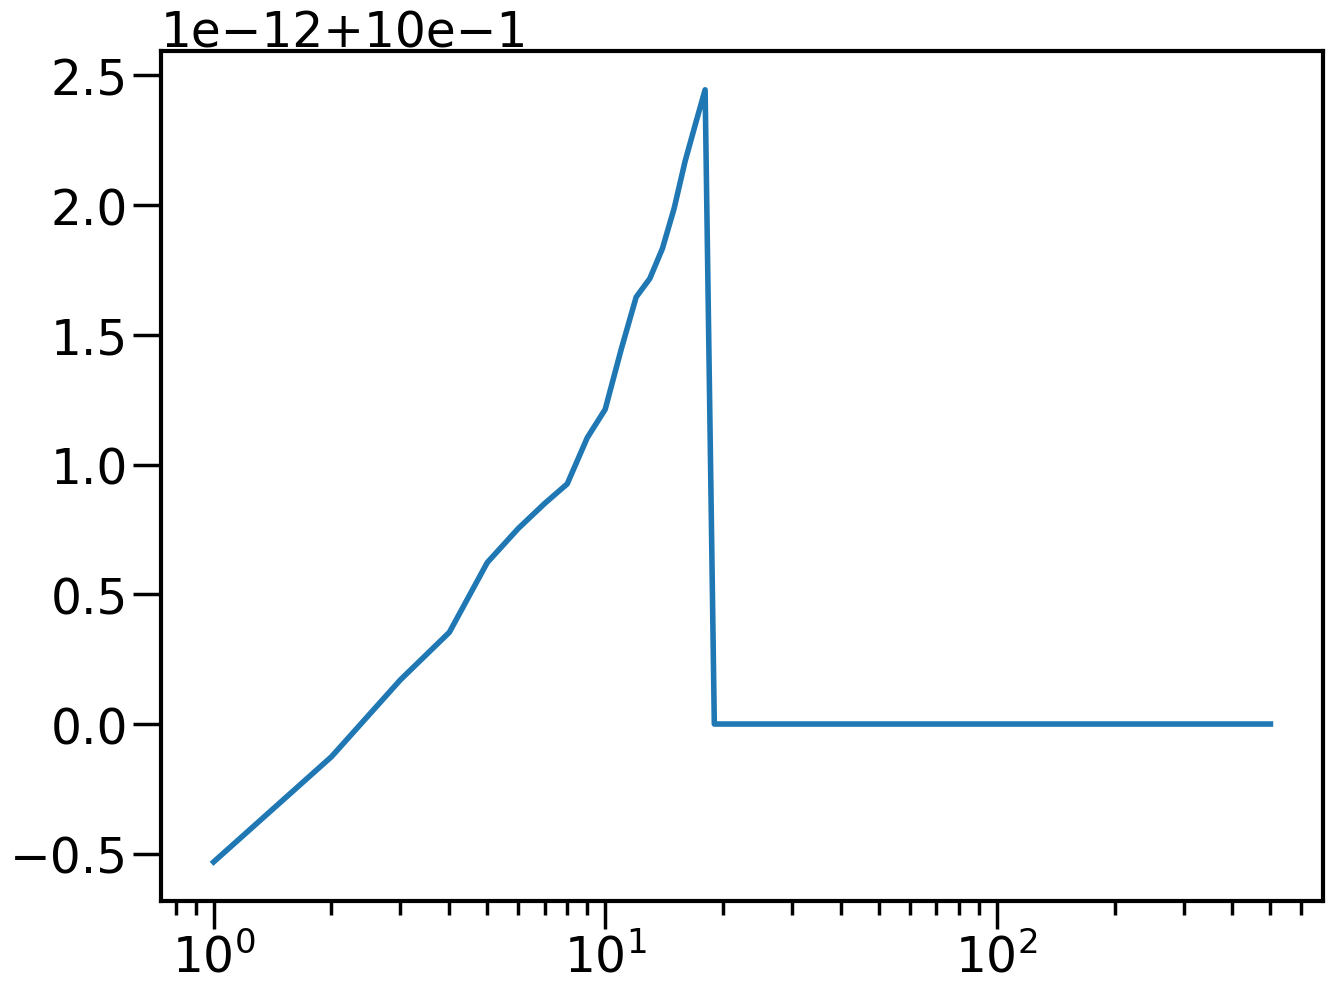

In [29]:
theta_i=0
l_i=100
plot(l+1,rr[l_i,:,theta_i])
xscale('log')

In [30]:
wig_d=wigner_d_parallel(m1,m2[0],theta,l,ncpu=10)
wd2=wigner_d2(m1, m2*1., theta, l*1., l_use_bessel=1.0e4)

np.all(np.isclose(wig_d.T,wd2[:,0,:]))

True

In [31]:
nside=32

In [33]:
beta=ring_beta(nside)
ylm=sYLM_recur(l_max=l_max,spins=(0,),beta=ring_beta(nside))

/home/deep/repos/SPHT/notebooks/../jax_healpix/YLM_jax.py:60: RuntimeWarning: divide by zero encountered in log
  log_Alm = -1 * logdiffexp(2 * np.log(l), 2 * np.log(m))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:15: RuntimeWarning: divide by zero encountered in log
  log_diff = np.log(1 - np.exp(log_b - log_a))
/home/deep/repos/SPHT/notebooks/../jax_healpix/utils.py:15: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(1 - np.exp(log_b - log_a))


In [34]:
npix=hp.nside2npix(nside)
th,phi=hp.pix2ang(nside,np.arange(npix))
th2,_=reshape_maps(nside,np.atleast_2d(th))
phi2,_=reshape_maps(nside,np.atleast_2d(phi))

/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:1942: UserWarning: Explicitly requested dtype int requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


In [35]:
#To get the spherical harmonics Ylm or order l,m in healpix format with nside, one does:
#https://stackoverflow.com/questions/65844496/healpy-getting-spherical-harmonics-from-as-function-of-pixel-l-and-m
l= nside*3
m=90

amplitude =.5j #0.5, 0.5j
alms  = np.zeros(  ((l+1)*(l+2) - (l-m)*(l-m+1))//2 , dtype=complex)
alms[-1] = amplitude
ylm_hp = hp.alm2map(alms, nside=nside, pol=False, sigma=0.0, lmax=l, mmax=m)

In [36]:
ylm_hp2,_=reshape_maps(nside,np.atleast_2d(ylm_hp))
# ylm_hp2/=np.cos(phi2*m)
ylm_hp2/=np.sin(-phi2*m)
x=np.sin(-phi2*m)==0
ylm_hp2=ylm_hp2.at[x].set(0)

In [37]:
phi_i=1

In [38]:
xx=np.isclose(ylm[0][l,m,:],ylm_hp2[0,:,phi_i])
np.all(xx)

False

In [39]:
rr=ylm[0][l,m,:]/ylm_hp2[0,:,phi_i]
# rr[~xx].max(),rr[~xx].min()#,ylm[0][l,m,:][~xx]

(-1.0, -0.9)

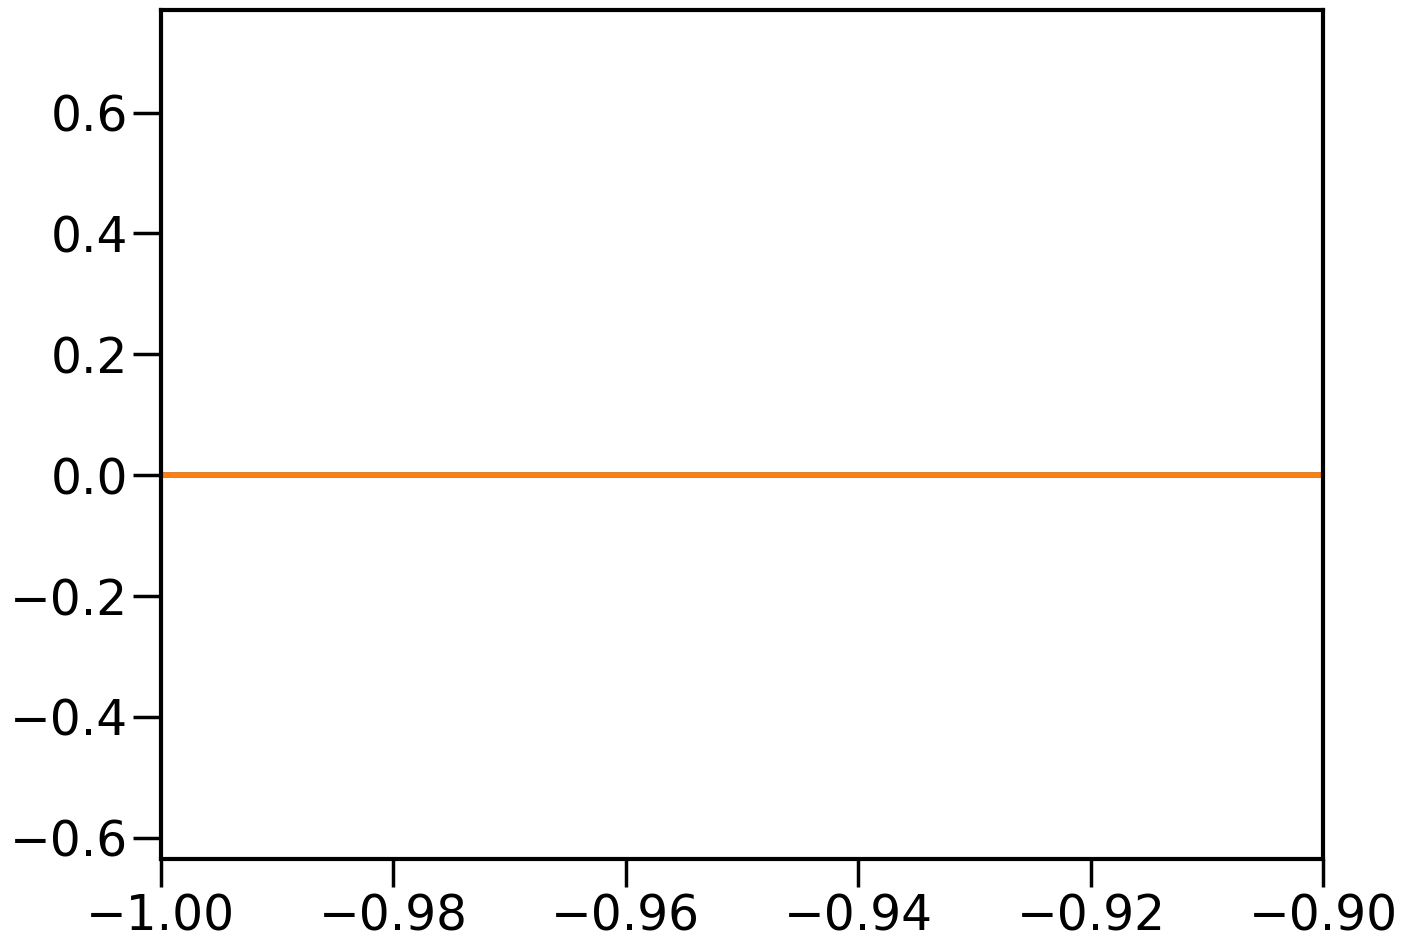

In [40]:
plot(beta,ylm[0][l,m,:])
plot(beta,ylm_hp2[0,:,phi_i])
xlim(-1,-.9)

(1e-13, 0.001)

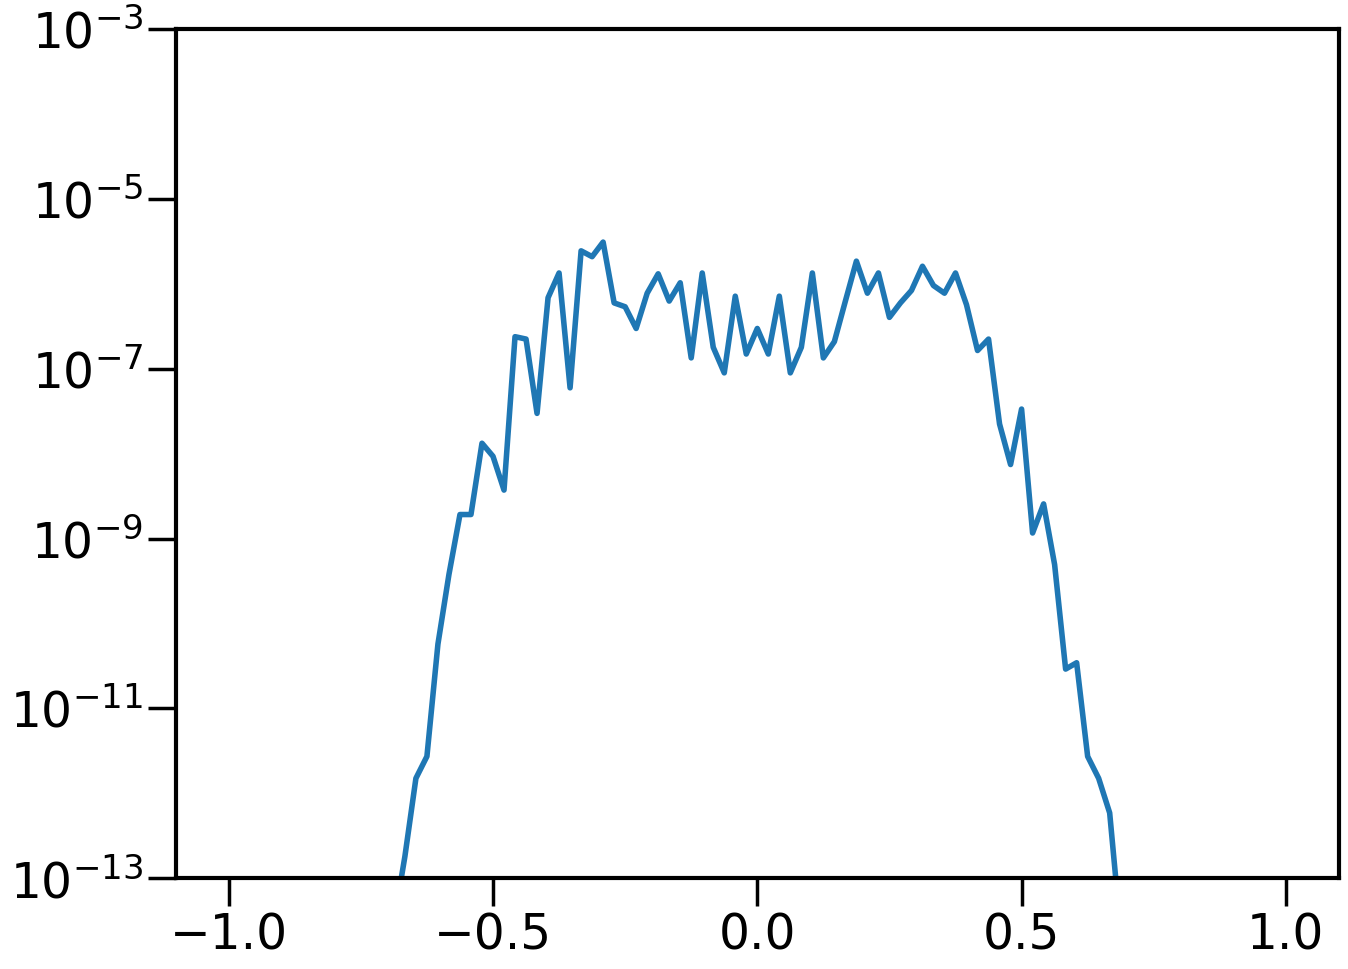

In [41]:
plot(beta,abs(ylm[0][l,m,:]-ylm_hp2[0,:,phi_i]))
yscale('log')
ylim(1.e-13,1.e-3)

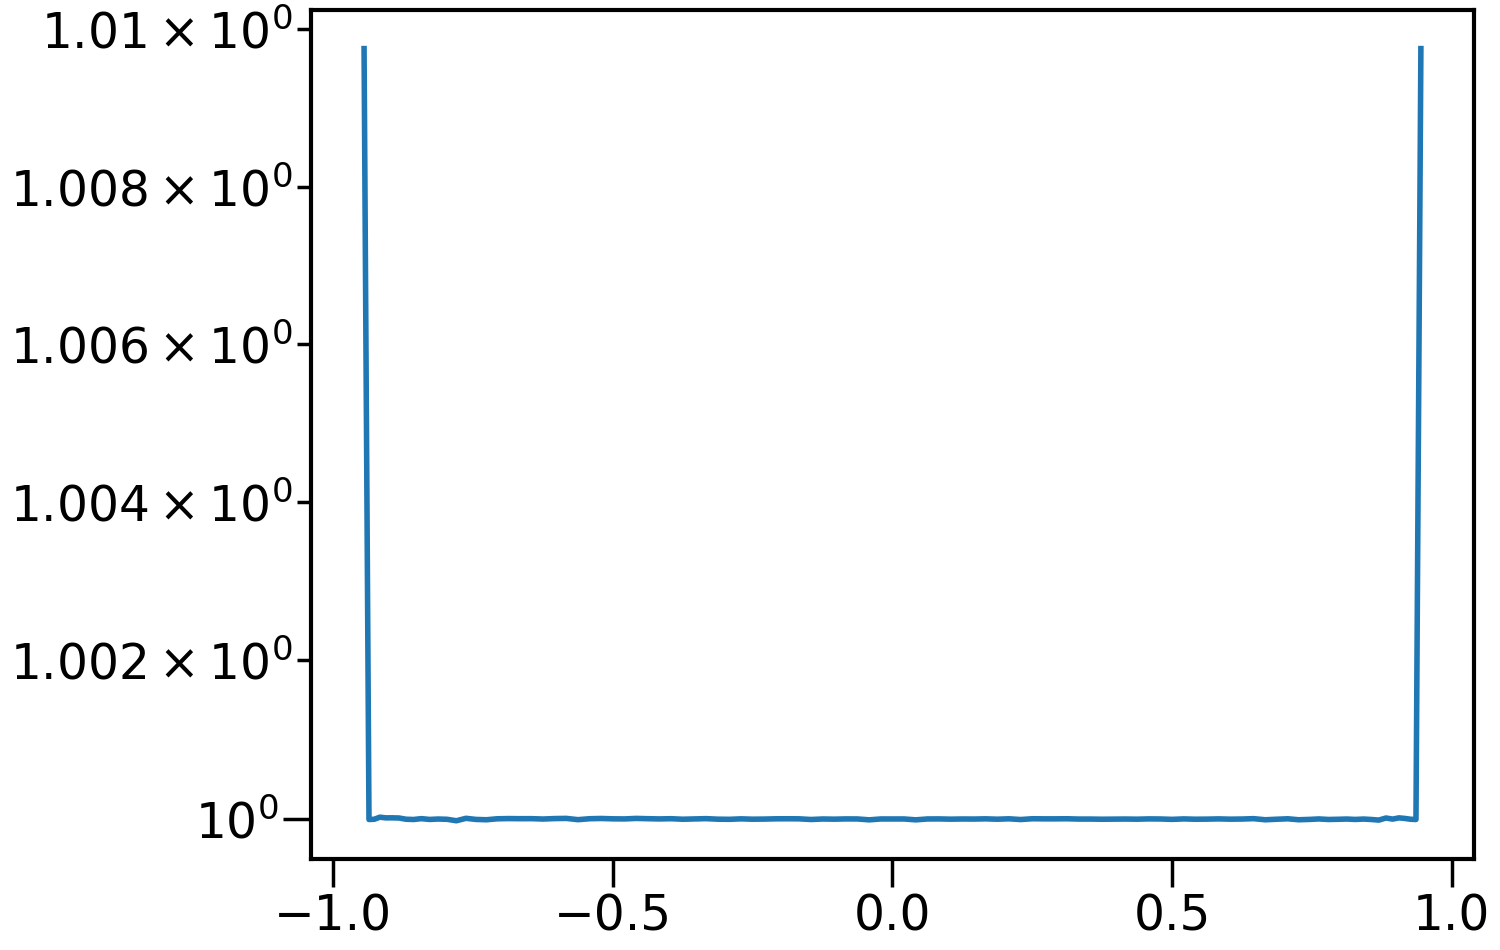

In [42]:
plot(beta,abs(ylm_hp2[0,:,phi_i]/ylm[0][l,m,:]))
yscale('log')

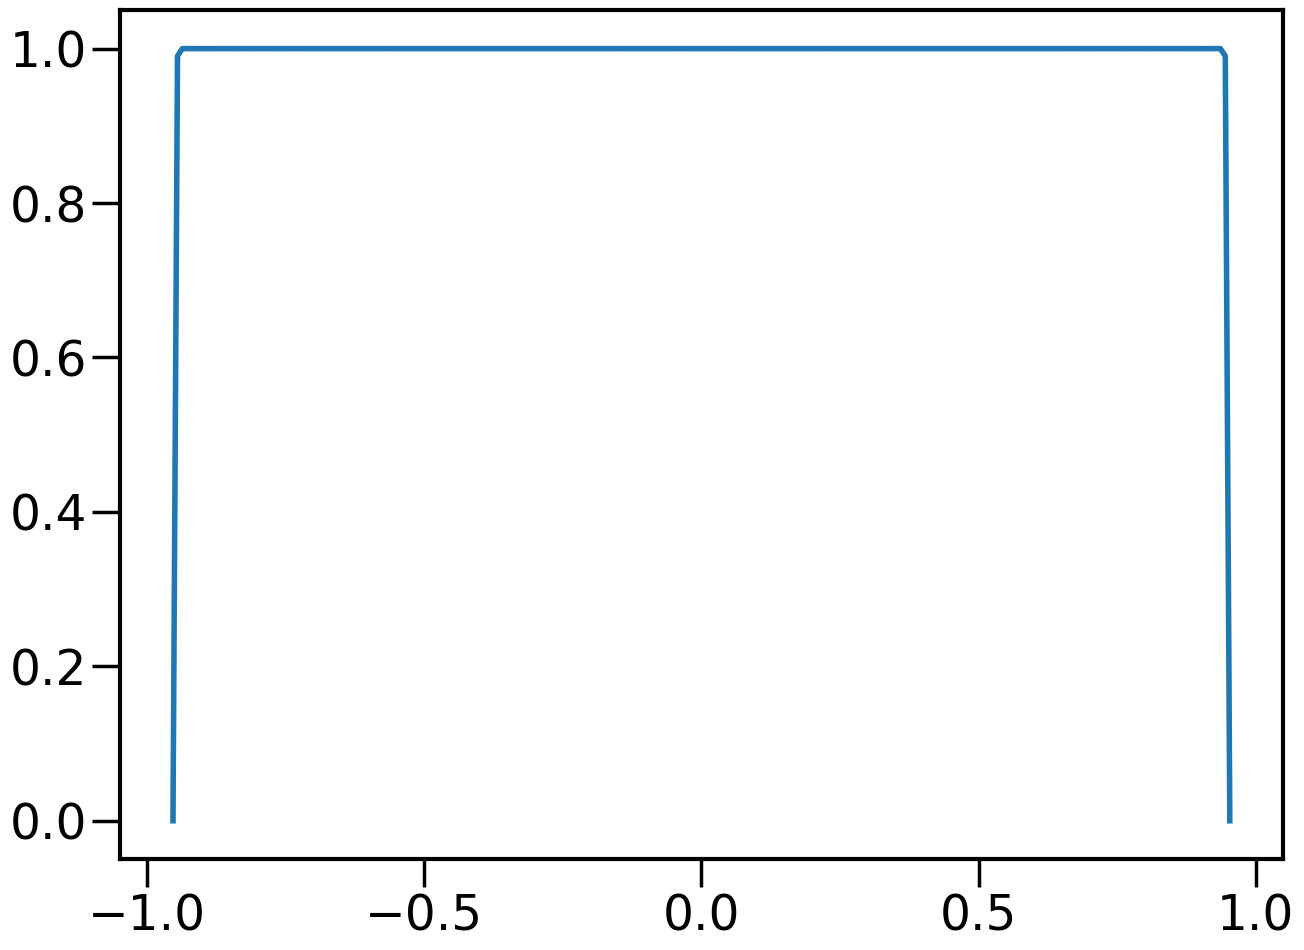

In [43]:
plot(beta,ylm[0][l,m,:]/ylm_hp2[0,:,phi_i])

In [44]:
beta_i=100
np.arccos(beta[beta_i]) ,l,m

(2.4382668, 96, 90)

In [45]:
ylm[0][l,m,beta_i]

3.7745088733043684e-13

In [46]:
ylm_hp2[0,beta_i,0]

DeviceArray(3.7745382e-13, dtype=float32)

In [47]:
ylm_hp2.shape

(1, 127, 128)

In [48]:
ylm[0].shape

(501, 501, 127)

In [49]:
#To get the spherical harmonics Ylm or order l,m in healpix format with nside, one does:
#https://stackoverflow.com/questions/65844496/healpy-getting-spherical-harmonics-from-as-function-of-pixel-l-and-m
l= 0
m=0

amplitude =.5 #0.5, 0.5j
alms  = np.zeros(  ((l+1)*(l+2) - (l-m)*(l-m+1))//2 , dtype=complex)
alms[-1] = amplitude
ylm_hp = hp.alm2map(alms, nside=nside, pol=False, sigma=0.0, lmax=l, mmax=m)

In [50]:
ylm_hp

array([0.1410474, 0.1410474, 0.1410474, ..., 0.1410474, 0.1410474,
       0.1410474])